In [1]:
# load libraries for data analysis, visualization and machine learning, and langchain and openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import langchain
import openai
import os
import fitz  # PyMuPDF
import requests
import pytesseract
from PIL import Image
import io

from collections import Counter
import itertools

from langchain.chat_models import ChatOpenAI
from langchain import PromptTemplate
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)



In [32]:
# import csv file from a defined url
url = "https://raw.githubusercontent.com/Mr-Helpful/preventable-deaths-scraper/main/src/data/reports-corrected.csv"
df = pd.read_csv(url)

In [3]:
# Check if there are any NaN values in the 'pdf_url' column
df['pdf_url'].isnull().sum()

0

In [4]:
# Function to perform OCR on PDF from URL
def ocr_pdf_from_url(url):
    response = requests.get(url)
    pdf = fitz.open(stream=response.content, filetype="pdf")

    text = ""
    for page_num in range(len(pdf)):
        page = pdf[page_num]
        pix = page.get_pixmap()
        image_bytes = pix.tobytes("png")
        image = Image.open(io.BytesIO(image_bytes))
        text += pytesseract.image_to_string(image)

    pdf.close()
    return text

In [29]:
# import OPENAI_API_KEY from .env file
from dotenv import load_dotenv
load_dotenv('/Users/edward.flahavan/text-analysis/.env')
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")


In [30]:
# Initialize the Chat llm using GPT-4
llm = ChatOpenAI( model_name="gpt-3.5-turbo-16k", temperature=0.7)

### Select suicide data


In [33]:
# Create a new dataframe with only the rows where the category column contains the string 'Suicide'
# na=False will treat NaN values as False, so rows with NaN in 'category' will not be included
df = df[df['category'].str.contains('Suicide', na=False)]
# count the number of rows
print(df.shape[0])

In [39]:
# Now just for these reports we will read in the PDFs
# Loop through each row in the DataFrame and perform OCR
for index, row in df.iterrows():
    pdf_url = row['pdf_url']
    try:
        if pd.isna(pdf_url):
            raise ValueError("No PDF URL provided")
        text = ocr_pdf_from_url(pdf_url)
        df.at[index, 'pdf_text'] = text
    except Exception:  # Catch any exception
        df.at[index, 'pdf_text'] = 'no pdf available'
        # Assign OCR text to a new column 'pdf_text'

In [40]:
# count the number of 'no pdf available' values in the 'pdf_text' column
df['pdf_text'].str.contains('no pdf available').sum()

1

In [41]:
# Filter the dataframe to remove rows where the pdf_text column contains the string 'no pdf available'
df = df[~df['pdf_text'].str.contains('no pdf available')]
# Filter the dataframe to remove rows where the pdf_url column it is NaN
df = df[~df['pdf_url'].isnull()]

<Axes: xlabel='pdf_text_token_count', ylabel='Count'>

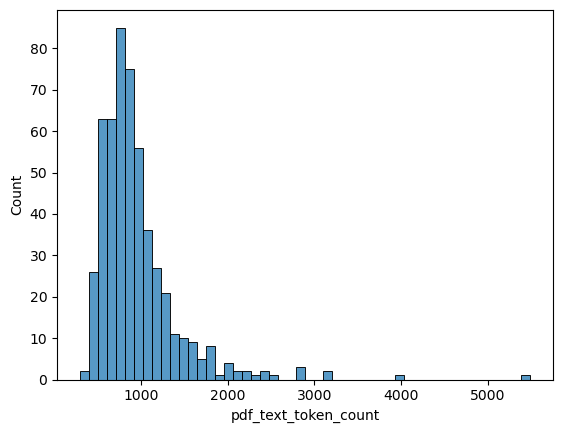

In [42]:
# create a new variable which is the count of the the number of tokens in 'pdf_text' for each row
df['pdf_text_token_count'] = df['pdf_text'].str.split().str.len()
# draw a histogram of the distribution of the number of tokens in 'pdf_text'
sns.histplot(data=df, x='pdf_text_token_count', bins=50)

In [43]:
# count the number of rows where the number of tokens in 'pdf_text' is greater than 3000
df[df['pdf_text_token_count'] > 3000].shape[0]
# Filter the dataframe to remove rows where the number of tokens in 'pdf_text' is greater than 5000
df = df[df['pdf_text_token_count'] < 3000]

In [51]:
# Write the dataframe to a csv file
df.to_csv('suicide-reports.csv', index=False)

### Write prompts for analysis

In [47]:
# Write the prompt to extract the coroner's concerns from the report
concerns_prompt = PromptTemplate(
    input_variables=["pdf_text"],
    template=""" You will be shown the text from a coroners report.
     Please extract the concerns raised by the coroner. 
     There's likely to be more than one. 
     Briefly summarise in one line each of their concerns. \n\n The text of the report is as follows {pdf_text} \n\nCoroner's concerns:
    """,
)
# Write the prompt to extract the circumstances of the death from the report
circumstances_prompt = PromptTemplate(
    input_variables=["pdf_text"],
    template=""" You will be shown the text from a coroners report.
     Please extract and summarise the circumstances of the death in one to two sentences. 
     Focus on the specifics of how they died and not personal information.
     \n\n The text of the report is as follows {pdf_text} \n\nCircumstances of the death:
    """,
)

In [46]:
# Write the loop to run through the dataset and extract the coroner's concerns 
for index, row in df.iterrows():
    concerns = concerns_prompt.format(pdf_text = row['pdf_text'])
    concerns_variable = llm([HumanMessage(content = concerns)])
    print(concerns_variable.content)
    df.at[index, 'coroner_concerns'] = concerns_variable.content

1. The Trust did not interrogate the Safeguarding and Vulnerability Report provided by British Transport Police, leading to a lack of understanding of the level of intent exhibited by Mrs. Porter.
2. The Trust staff did not contact British Transport Police to gather more information about the incident, such as viewing CCTV footage or requesting a summary of the footage.
3. The Trust's report inaccurately stated that there were no identified service delivery issues, despite reflection upon missed opportunities to investigate the events.
4. The Trust's reliance on partial information resulted in missed opportunities for appropriate referral and care.
5. The Trust's systems to avoid reliance on short summaries from British Transport Police were not deemed robust enough, raising concerns about the thoroughness of information scrutiny.
6. The Coroner requests action to be taken by the Oxleas NHS Trust to prevent future deaths.
1. Lack of local and national system of in-cell ligature point r

In [49]:
# Write the loop to run through the dataset and generate the circumstances of the death
for index, row in df.iterrows():
    circumstances = circumstances_prompt.format(pdf_text = row['pdf_text'])
    circumstances_variable = llm([HumanMessage(content = circumstances)])
    print(circumstances_variable.content)
    df.at[index, 'circumstances_of_death'] = circumstances_variable.content

On February 19, 2023, Denise Jane Porter jumped onto the tracks of Platform 2 at Turnham Green Underground Station and was struck by an oncoming train, resulting in multiple injuries and decapitation. She was under the care of Oxleas NHS Trust Adults' Community Mental Health Team and believed she had early onset dementia, although there was no formal diagnosis for her mental condition at the time of her death.
Wyndham Richard Thomas, a serving prisoner, died from ligature asphyxiation in his cell at HMP Nottingham. There were concerns about the lack of ligature point risk assessments and the absence of designated safer cells within the prison, which could have potentially prevented his self-harm and death.
Morgan-Rose Hart, an 18-year-old who was detained under the Mental Health Act, died as a result of a hypoxic ischemic brain injury and cardiac arrest caused by ligature misadventure. The coroner's report highlights multiple failings in her care, including inadequate transfer of medic

In [80]:
# Create the categories for the circumstances of death
# Create an llm prompt that takes as an input the circumstances of death for a large number of cases and is asked to create 8-10 categories for the circumstances of death 
circumstances_categories_prompt = PromptTemplate(
    input_variables=["circumstances"],
    template=""" You will be shown the circumstances of death for a large number of cases of suicide.

     Please create 10-12 categories that capture the way that the individual died in a way that is mutually exclusive and collectively exhaustive. 

     For each category please provide a one sentence description of the category and a few specific examples of the circumstances of death that are in that category.

     If the way that the person died is not included, please say 'Not stated'.

     \n\n You can include an 'Other' category for hard to categorise circumstances.

     If there are not enough cases to create 10-12 categories, simply reply 'not enough cases'.
     
     \n\n The circumstances of death are as follows {circumstances} \n\nCircumstances of death categories:
    """,
)

In [55]:
# Write a prompt to generate the categories for the coroner's concerns
concerns_categories_prompt = PromptTemplate(
    input_variables=["concerns"],
    template=""" You will be shown the concerns raised by the coroner for a large number of cases.
     Please create 10-12 categories for the concerns raised by the coroner. 
     For each category please provide a one sentence description of the category and a few specific examples of the concerns raised by the coroner that are in that category.
     \n\n You can inlcude an 'other' category for hard to categorise concerns.
     \n\n The concerns raised by the coroner are as follows {concerns} \n\nConcerns raised by the coroner categories:
    """,
)

### Create categories for circumstances of death and concerns

In [81]:
# specify the llm as using gpt-4
llm_4 = ChatOpenAI( model_name="gpt-4-1106-preview", temperature=0.7)

# First, we shuffle the DataFrame
shuffled_df = df.sample(frac=1).reset_index(drop=True)

# Initialize an empty list to store all categories from all batches
all_categories = []

# Process the DataFrame in batches of 50
batch_number = 1
for start in range(0, len(shuffled_df), 100):
    # Create a batch
    batch = shuffled_df['circumstances_of_death'][start:start+50]

    # Concatenate the batch into a single string with line breaks
    batch_string = '\n'.join(batch)

    # Create the prompt by inserting the batch into the prompt template
    circumstances_categories = circumstances_categories_prompt.format(circumstances=batch_string)

    # Run the language model to generate the categories for this batch
    categories_result = llm_4([HumanMessage(content = circumstances_categories)])

    # Add a batch label and the result to the list
    batch_label = f'Batch {batch_number}: '
    all_categories.append(batch_label + categories_result.content)

    # Increment the batch number for the next loop iteration
    batch_number += 1

# Concatenate all categories into a single variable
final_categories = '\n'.join(all_categories)


In [82]:
print(final_categories)

Batch 1: 1. **Overdose on Medication or Substances**
   - Description: Death due to intentionally ingesting or administering an excess of pharmaceutical drugs, recreational drugs, or other chemical substances.
   - Examples: Mr. Etherington's overdose of Amitriptyline and Norepinephrine; Nigel Harper's overdose of sedative medications; Katie Anne Williams' overdose leading to serotonin toxicity.

2. **Hanging or Suspension**
   - Description: Death by asphyxiation due to self-suspension with a ligature around the neck.
   - Examples: Denton Donovan Duhaney, Zachary KLEMENT, Kieran Joseph Kevan Crimmins, Finnian Gabriel Denney Kitson, Mr. Brown, Stuart Megginson Baumber, David Wood, Rebecca Clare Pykett, the unnamed deceased found at home, Siwan Smith, Jane Diane Livingston, Danny James Holt-Scapens, Max Turbutt, Kieran Luke Hubbard, Daniele Rhian Robinson.

3. **Self-Harm Leading to Death**
   - Description: Death due to self-inflicted injuries intended to cause severe harm or fatality

In [83]:

# Create the master categories prompt template
master_categories_prompt = PromptTemplate(
    input_variables=["batched_categories"],
    template="""You will now see a long list containing categories. The categories are in batches since the previous analysis has looked at a subset of the data to categorise the contents. 

Your task is to create the master categories. You should create 10-12 of these and include an 'other' category. You should include all the categories that appear regularly in the batches you see in the data.

The batched categories are as follows: {batched_categories} 

\n\nMaster categories:
"""
)

# Use the final_categories variable from the previous step as the input
final_batched_categories = final_categories

# Create the prompt by inserting the batched categories into the prompt template
master_categories = master_categories_prompt.format(batched_categories=final_batched_categories)

# Specify the llm as using gpt-4
llm_4 = ChatOpenAI(model_name="gpt-4-1106-preview", temperature=0.7)

# Run the language model to generate the master categories
master_categories_result = llm_4([HumanMessage(content = master_categories)])

# Output the master categories
print(master_categories_result.content)

# save this as a variable
circumstances_master_categories = master_categories_result.content

Based on the provided batched categories, here are the proposed master categories for categorizing the circumstances of death by suicide:

1. **Hanging/Suspension**
   - Includes all instances of death by self-suspension using a ligature.

2. **Overdose/Intoxication**
   - Covers deaths by intentional overdose of medication, drugs, or ingestion of toxic substances.
  
3. **Sharp Force Trauma**
   - Encompasses deaths resulting from self-inflicted lacerations or stabbing.

4. **Asphyxiation**
   - Includes all forms of asphyxiation, such as suffocation by plastic bag, strangulation by ligature (not involving suspension), and other means of oxygen deprivation.

5. **Impact with Vehicles or Trains**
   - Consists of deaths by stepping into the path of moving vehicles or trains, including collisions and train impacts.

6. **Jumping/Falling from Height**
   - Includes deaths resulting from jumping or falling from elevated positions.

7. **Drowning**
   - Covers instances of death by intenti

In [57]:
# Now we will create the prompts to generate the categories for the coroner's concerns

# Initialize an empty list to store all categories from all batches
all_categories = []

# Process the DataFrame in batches of 90
batch_number = 1
for start in range(0, len(shuffled_df), 90):
    # Create a batch
    batch = shuffled_df['coroner_concerns'][start:start+50]

    # Concatenate the batch into a single string with line breaks
    batch_string = '\n'.join(batch)

    # Create the prompt by inserting the batch into the prompt template
    circumstances_categories = concerns_categories_prompt.format(concerns=batch_string)

    # Run the language model to generate the categories for this batch
    categories_result = llm_4([HumanMessage(content = circumstances_categories)])

    # Add a batch label and the result to the list
    batch_label = f'Batch {batch_number}: '
    all_categories.append(batch_label + categories_result.content)

    # Increment the batch number for the next loop iteration
    batch_number += 1

# Concatenate all categories into a single variable
final_categories = '\n'.join(all_categories)

In [ ]:
print(final_categories)

In [62]:
# Create the master categories for concerns

# Use the final_categories variable from the previous step as the input
final_batched_categories = final_categories

# Create the prompt by inserting the batched categories into the prompt template
master_categories = master_categories_prompt.format(batched_categories=final_batched_categories)

# Run the language model to generate the master categories
master_categories_result = llm_4([HumanMessage(content = master_categories)])

# Output the master categories
print(master_categories_result.content)

concerns_master_categories = master_categories_result.content


Creating master categories requires synthesizing the recurring themes from the batched categories provided. Here are 12 master categories that encompass the broad concerns raised across the various batches:

1. **Mental Health Services and Crisis Management**
   - Integration of concerns related to availability, coordination, quality of mental health services, crisis response, and support for vulnerable individuals after role loss or discharge.

2. **Healthcare Coordination and Continuity**
   - Encompasses issues with interagency communication, continuity of care, transition of care, and service coordination, including for children and adolescents.

3. **Risk Assessment and Suicide Prevention**
   - Combines concerns about suicide and self-harm risk management, including in custodial settings, public spaces, and mental health crisis situations.

4. **Communication and Information Sharing**
   - Focuses on the effective exchange of critical information among healthcare providers, law e

In [6]:
## Create a prompt that will look at all the values in the variable 'this_report_is_sent_to' and generate a list of 8-12 mutually exclusive and collectively exhaustive categories for the recipients of the report

# Write the prompt
recipient_categories_generation_prompt = PromptTemplate(
    input_variables=["recipients"],
    template="""You will now see a long list containing names of organisations. I need you to create a list of 8-12 categories for these organisations that are mutually exclusive and collectively exhaustive.
    
You can include an 'other' category for organisations that are not easily categorised. You should also include an 'Unknown' category for organisations that are not named.

The list of recipents are as follows: {recipients} 

\n\nOverall categories:
"""
)

Oxleas NHS Foundation Trust nan Essex Partnership University Trust | Essex County Council Essex Partnership NHS Trust | British Transport Police Home Office | Department of Health and Social Care | Department for Digital Culture Media and Sport | Ofcom | Google | Amazon | British Transport Police | National Police Chiefs’ Council Stretton Medical Centre OFSTED | Department for Education | Reading Borough Council Devon Partnership NHS Trust | Langdon Hospital South West London and St George’s Mental Health NHS Trust nan Intensive Care Medicine Essex Partnership University Trust Southern Health Foundation Trust | Hampshire and Isle of Wight Integrated Care Board | NHS England Gender Identity Clinic | NHS England | Surrey and Borders NHS Partnership Trust | The Royal College of General Practitioners Oxleas NHS Foundation Trust Barnet Enfield and Haringey Mental Health NHS Trust Betsi Cadwaladr University Local Health Board Pennine Care NHS Foundation Trust Birmingham and Solihull Mental H

In [12]:
# Create a string of all the recipients
recipients = ' '.join(df['this_report_is_being_sent_to'].astype(str))

# Create the prompt by inserting the batched categories into the prompt template
recipient_categories = recipient_categories_generation_prompt.format(recipients=recipients)

# Specify the llm as using gpt-4 with the large context window
llm_4 = ChatOpenAI(model_name="gpt-4-1106-preview", temperature=0.7)

# Run the language model to generate the master categories
recipient_categories_result = llm_4([HumanMessage(content = recipient_categories)])

# Output the master categories
print(recipient_categories_result.content)

# save this as a variable
recipient_master_categories = recipient_categories_result.content

Here is a list of categories that could be used to classify the organizations mentioned:

1. National Health Service (NHS) and Healthcare Trusts
   - Includes NHS Foundation Trusts, Integrated Care Boards, Local Health Boards, University Health Boards, Mental Health Trusts, and other healthcare-related services.

2. Government Departments and Public Bodies
   - Includes national departments such as the Department of Health and Social Care, Department for Education, Home Office, and other government entities.

3. Police, Justice, and Correctional Services
   - Encompasses police forces, the British Transport Police, National Police Chiefs’ Council, HM Prison and Probation Service, Ministry of Justice, coroners, and related legal services.

4. Regulatory Authorities and Professional Bodies
   - Includes Ofcom, the Care Quality Commission, Medicines & Healthcare products Regulatory Agency, and professional colleges such as the Royal College of General Practitioners.

5. Local Authorities 

### Categorise each case

In [84]:
circumstances_categories_prompt = PromptTemplate(
    input_variables=["master_categories" , "circumstances_of_death"],
    template=""" You will be shown the circumstances of death for an individual case.
    You will be asked to categorise the circumstances of death into one of the following categories:

    {master_categories}

    You should reply with only one of the categories listed above. Only provide the name of the category, not the description and no notation or punctuation. For example, if you think the circumstances of death are best described as 'Asphyxiation', you should reply with 'Asphyxiation' 

    The circumstances of death are as follows {circumstances_of_death} \n\nCircumstances of death category:
    """,
)

In [ ]:
# Use the regular gpt-4 model. No need for the larger context window.
llm_4 = ChatOpenAI(model_name="gpt-4", temperature=0.7)

# Write a loop to run through the dataset and generate the categories for the circumstances of death
for index, row in df.iterrows():
    circumstances_categories = circumstances_categories_prompt.format(circumstances_of_death = row['circumstances_of_death'], master_categories = circumstances_master_categories)
    circumstances_categories_variable = llm_4([HumanMessage(content = circumstances_categories)])
    print(circumstances_categories_variable.content)
    df.at[index, 'circumstances_of_death_category'] = circumstances_categories_variable.content

In [67]:
# and the same for coroners concerns
concerns_categories_prompt = PromptTemplate(
    input_variables=["master_categories" , "coroner_concerns"],
    template=""" You will be shown the concerns raised by the coroner for an individual case.

    You will be asked to categorise the concerns raised by the coroner into one of the following categories:
    
    {master_categories}
 
    You should categorise all of the coroner's conerns into one of the categories listed above. Only provide the name of the category, not the description. For example, if you think the coroner's concerns are best described as 'Police Response and Coordination', you should reply with 'Police Response and Coordination'. 

    Where there are multiple concerns, you should list the conerns separated by ; . For example, if you think the coroner's concerns are best described as 'Police Response and Coordination' and 'Police Training and Policy', you should reply with 'Police Response and Coordination ; Police Training and Policy'.

    Concerns raised by the coroner: {coroner_concerns} \n\nCoroner's concerns category:
    """,
)

In [ ]:
# Use the regular gpt-4 model. No need for the larger context window.
llm_4 = ChatOpenAI(model_name="gpt-4", temperature=0.7)

# Write a loop to run through the dataset and generate the categories for the coroner conerns
for index, row in df.iterrows():
    concerns_categories = concerns_categories_prompt.format(coroner_concerns = row['coroner_concerns'], master_categories = concerns_master_categories)
    concerns_categories_variable = llm_4([HumanMessage(content = concerns_categories)])
    print(row)
    print(concerns_categories_variable.content)
    df.at[index, 'coroner_concerns_category'] = concerns_categories_variable.content

In [13]:
# Categorise the recipients

# and the same for coroners concerns
recipient_categories_prompt = PromptTemplate(
    input_variables=["recipient_categories" , "recipient"],
    template=""" You will be shown the recipient or recipients of a report.

    You will be asked to categorise recipient(s) into one of the following categories:
    
    {recipient_categories}
 
    You should categorise all of the recipients into one of the categories listed above. Only provide the name of the category, not the description and no punctuation. For example, if you think the recipient is best described as 'Police', you should reply with 'Police'. 

    Where there are multiple recipients, you should list the categories separated by ; .

    Recipient(s): {recipient} \n\nRecipient category(ies):
    """,
)

In [15]:
# Use the regular gpt-4 model. No need for the larger context window.
llm_4 = ChatOpenAI(model_name="gpt-4", temperature=0.7)

# Write a loop to run through the dataset and generate the categories for the coroner conerns
for index, row in df.iterrows():
    recipient_categories = recipient_categories_prompt.format(recipient = row['this_report_is_being_sent_to'], recipient_categories = recipient_master_categories)
    recipient_categories_variable = llm_4([HumanMessage(content = recipient_categories)])
    print(row)
    print(recipient_categories_variable.content)
    df.at[index, 'recipient_category'] = recipient_categories_variable.content

date_of_report                                                            21/12/2023
ref                                                                        2023-0548
deceased_name                                                          Denise Porter
coroner_name                                                                     NaN
coroner_area                                                             London West
category                                                         Suicide (from 2015)
this_report_is_being_sent_to                             Oxleas NHS Foundation Trust
report_url                         https://www.judiciary.uk/prevention-of-future-...
pdf_url                            https://www.judiciary.uk/wp-content/uploads/20...
reply_urls                                                                       NaN
circumstances                      On 19th February 2023, the deceased jumped on ...
concerns                           British Transport Police made 

In [16]:
print(df['recipient_category'])

0      National Health Service (NHS) and Healthcare T...
1                                          Other/Unknown
2      National Health Service (NHS) and Healthcare T...
3      National Health Service (NHS) and Healthcare T...
4      Government Departments and Public Bodies; Regu...
                             ...                        
508                                        Other/Unknown
509                                        Other/Unknown
510                                        Other/Unknown
511                                        Other/Unknown
512    Police, Justice, and Correctional Services; Go...
Name: recipient_category, Length: 513, dtype: object


In [17]:
# write the dataframe to a csv file
df.to_csv('suicide-reports.csv', index=False)

### Analysis of the results

<Axes: xlabel='count', ylabel='circumstances_of_death_category'>

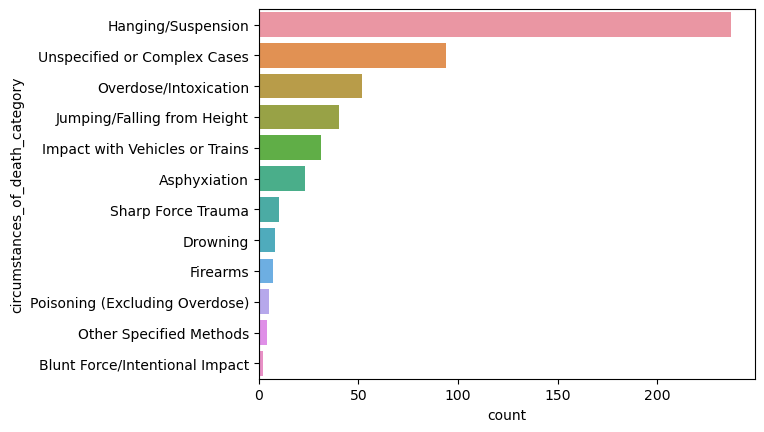

In [87]:
# Create a bar chart of the number of cases in each category of circumstances of death. Plot the chart in descending order of the number of cases in each category. Plot the bars horiztonally
sns.countplot(y='circumstances_of_death_category', data=df, order=df['circumstances_of_death_category'].value_counts().index)

In [77]:
# Now we can look at coroner's concerns
from collections import Counter
import itertools
# Initialize counters
category_count = Counter()
co_occurrence_count = Counter()


# Iterate through each row
for row in df['coroner_concerns_category']:
    categories = [cat.strip() for cat in row.split(';')]
    category_count.update(categories)
    
    # For co-occurrences
    for combo in itertools.combinations(categories, 2):
        co_occurrence_count[combo] += 1

# Display results
print("Individual Category Counts:")
print(category_count)
print("\nCategory Co-occurrence Counts:")
print(co_occurrence_count)

Individual Category Counts:
Counter({'Healthcare Coordination and Continuity': 261, 'Policy, Procedure, and Protocol Compliance': 223, 'Communication and Information Sharing': 218, 'Mental Health Services and Crisis Management': 206, 'Risk Assessment and Suicide Prevention': 184, 'Staffing, Training, and Resource Allocation': 177, 'Investigation, Reporting, and Accountability': 133, 'Patient Safety and Institutional Oversight': 105, 'Medication and Substance Misuse Management': 49, 'Equity and Accessibility in Healthcare': 45, 'Access to Harmful Substances and Content': 35, 'Emergency Medical Services and Response': 23, 'Investigation, Reporting, and Accountability.': 2, 'Medication and Substance Misuse Management.': 1, 'Healthcare Coordination and Continuity.': 1, 'Other': 1})

Category Co-occurrence Counts:
Counter({('Mental Health Services and Crisis Management', 'Healthcare Coordination and Continuity'): 112, ('Healthcare Coordination and Continuity', 'Communication and Information

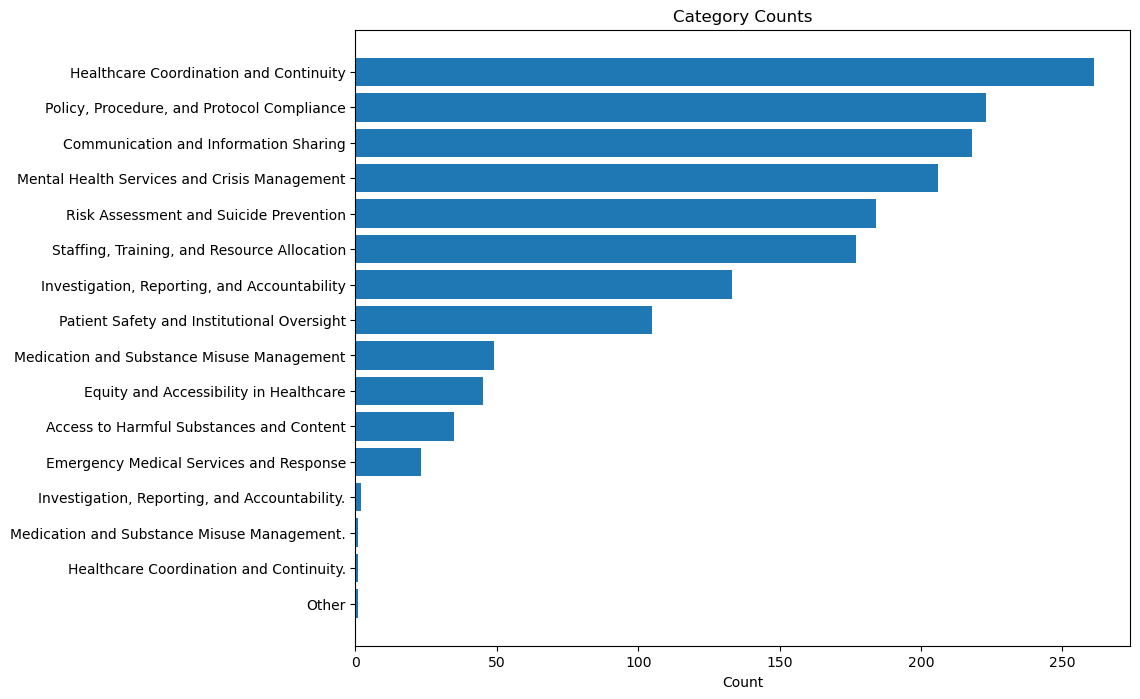

In [78]:
# Now we can plot the coroner's concerns categories

# Sorting categories by count
sorted_categories = {k: v for k, v in sorted(category_count.items(), key=lambda item: item[1], reverse=True)}

# Creating the bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(sorted_categories.keys()), list(sorted_categories.values()))
plt.xlabel('Count')
plt.title('Category Counts')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.show()

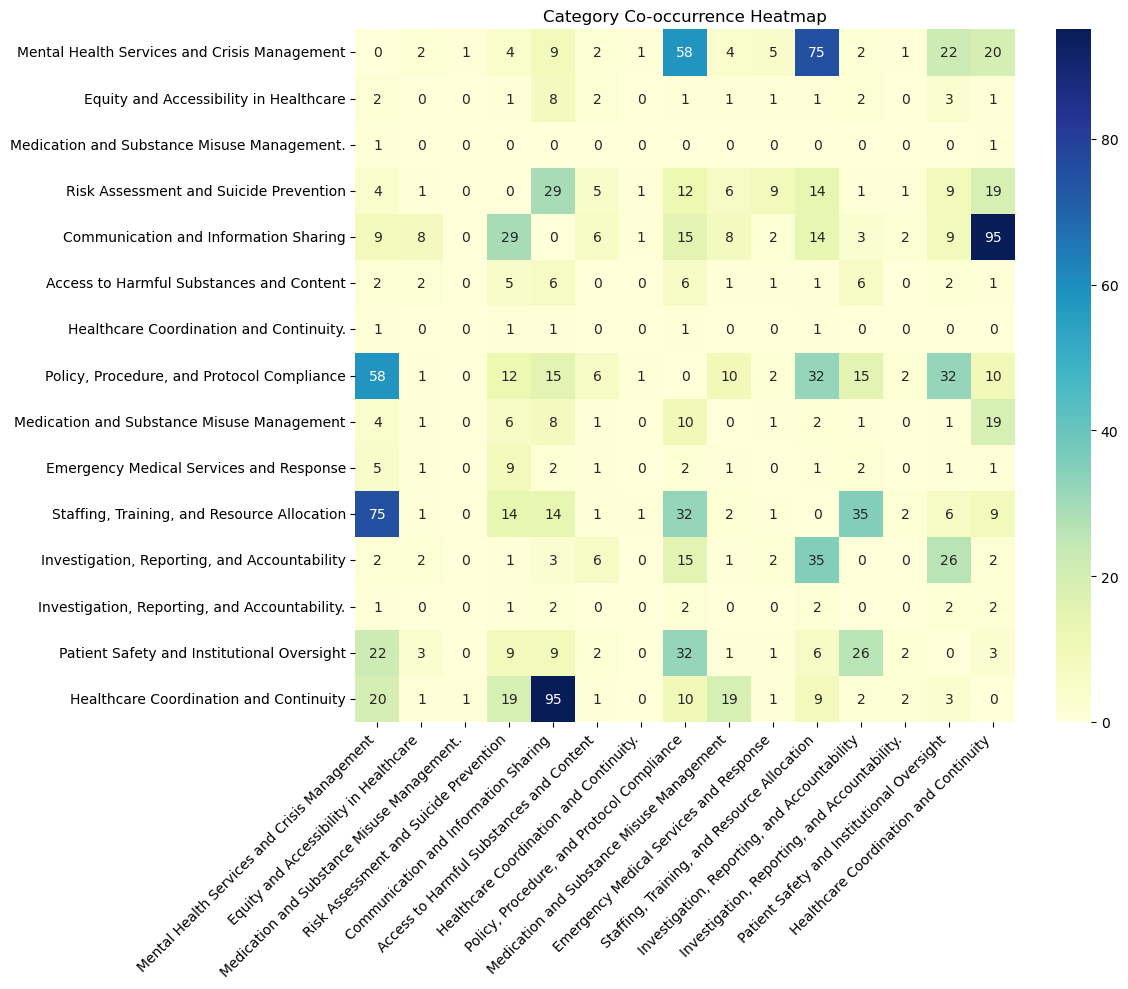

In [79]:
# Create a a heatmap of the co-occurrence of categories

# Create a list of all unique categories
unique_categories = list(set(itertools.chain.from_iterable(co_occurrence_count.keys())))

# Create an empty co-occurrence matrix
co_occurrence_matrix = pd.DataFrame(0, index=unique_categories, columns=unique_categories)

# Populate the matrix with co-occurrence counts
for (cat1, cat2), count in co_occurrence_count.items():
    co_occurrence_matrix.at[cat1, cat2] = count
    co_occurrence_matrix.at[cat2, cat1] = count  # for symmetry

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, annot=True, cmap="YlGnBu")
plt.title("Category Co-occurrence Heatmap")
# Adjusting label positions
plt.xticks(rotation=45, ha='right', ticks=np.arange(len(unique_categories)) + 0.5, labels=unique_categories)
plt.yticks(rotation=0, ticks=np.arange(len(unique_categories)) + 0.5, labels=unique_categories)
plt.tight_layout()  # Adjust layout
plt.show()
